In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time 

In [2]:
class BlackJack():
    
    def __init__(self,policy):
        
        # Assume the deck is infinitly large
        self.decks = [i for i in range(1,11)]
        
        # why 32 observation states?
        # the sum of two face-down cards for player can be 2~22
        # while the one face-up card from the dealer can be 1~11
        # so all possible sums range from 2~33, which contains 32 observation states
        # Even though in our intuition, if the player already has sum of 21, he/she shouldn't hit
        # but in programming logic, we'll keep these situations
        self.player_sum_states = [i for i in range(2,34)]
        
        self.dealer_face_up = [i for i in range(1,12)]
        self.actions = ['hit','stick']
        
        self.player_thres = policy
        self.dealer_thres = 17
        
    # Execute the start of the game: 2 cards for player and dealer each
    def draw_hands(self):
        
        return [np.random.choice(self.decks),
                np.random.choice(self.decks)]
    
    # Execute drawing card
    def draw_card(self):
        
        return np.random.choice(self.decks)
    
    # Decide whether there is a usable ace at hand currently
    def Ace(self,cards):
        if (1 in cards) and (sum(cards)+10<=21):
            return True
            
        else:
            return False
        
    # Calculate the current sum of cards at hand
    def CuurentSum(self,cards,thres):
        
        if self.Ace(cards):
            if sum(cards)+10>21:
                return 'Bust'

            elif sum(cards)+10>=thres:
                return 'Stick'

            else:
                return 'Hit'
        else:
            if sum(cards)>21:
                return 'Bust'

            elif sum(cards)>=thres:
                return 'Stick'

            else:
                return 'Hit'
        
    # If game ends, calculate player's score of this round of game
    def Score(self,player_track,dealer_track,player_sum,dealer_sum):
        if player_track[-1]=='Bust':
            return -1
        elif dealer_track[-1]=='Bust':
            return 1
        elif player_sum == dealer_sum:
            return 0
        else:
            return 2*(player_sum>dealer_sum)-1
            
    
    # Let's get the party started
    def GameBegins(self):
        
        # 1. Game Starts, two cards for dealer and player for each
        player_start,dealer_start = self.draw_hands(),self.draw_hands()
        
        self.player_hand = player_start.copy()
        self.dealer_hand = dealer_start.copy()

        self.track_player = player_start.copy()
        self.track_dealer = dealer_start.copy()
        # ---------------------------------------------------------
        
        
        # 2. Player will decide the action according to the current state:
        player_done = False
        dealer_done = False
        
        while player_done==False:
            action = self.CuurentSum(self.player_hand,self.player_thres)
            
            if action=='Stick':
                self.track_player.append(action)
                player_done=True
                
            if action=='Hit':
                self.track_player.append(action)
                new_draw = self.draw_card()
                self.player_hand.append(new_draw)
                self.track_player.append(new_draw)
            
            if action=='Bust':
                self.track_player.append(action)
                player_done=True
                dealer_done=True
        # ---------------------------------------------------------
        
        
        # 3. If the player stops acting, turn to dealer
        while dealer_done == False:
            action = self.CuurentSum(self.dealer_hand,self.dealer_thres)
            
            if action=='Stick':
                self.track_dealer.append(action)
                dealer_done=True
                
            if action=='Hit':
                self.track_dealer.append(action)
                new_draw = self.draw_card()
                self.dealer_hand.append(new_draw)
                self.track_dealer.append(new_draw)
            
            if action=='Bust':
                self.track_dealer.append(action)
                dealer_done=True
        # ---------------------------------------------------------       
        
        # 4. Get the final score of player:
        self.score = self.Score(self.track_player,
                                self.track_dealer,
                                sum(self.player_hand),
                                sum(self.dealer_hand))
        
#         if self.score==1:
#             print('you win')
#         if self.score==-1:
#             print('you lost')  
#         if self.score==0:
#             print('draw')
        # ---------------------------------------------------------

In [3]:
def PolicyEvaluation(iteration,policy):
    
    q_sa = {}
    
    # each iteration is an episode
    for i in range(iteration):
        
        game = BlackJack(policy)
        game.GameBegins()
        
        state = [sum(game.track_player[:2])]
        state.append(game.track_dealer[0])
        state = tuple(state)
        
        if state not in q_sa.keys():
            q_sa[state] = [1,game.score]
        else:
            q_sa[state][0]+=1
            q_sa[state][1]+=game.score
            
    return q_sa

In [4]:
def MultiplePolicy():
    
    policy_eval = {}
    for i in range(10,22):
        
        start = time.time()
        
        policy_eval[i]=PolicyEvaluation(500000,i)
        
        end = time.time()
        print('Monte Carlo evaluation of policy{} finished'.format(i) )
        print('time cost {}seconds'.format(np.round(end-start,2)))
        print()
    
    return policy_eval

In [5]:
policy_eval = MultiplePolicy()

Monte Carlo evaluation of policy10 finished
time cost 54.36seconds

Monte Carlo evaluation of policy11 finished
time cost 50.3seconds

Monte Carlo evaluation of policy12 finished
time cost 51.76seconds

Monte Carlo evaluation of policy13 finished
time cost 51.89seconds

Monte Carlo evaluation of policy14 finished
time cost 53.43seconds

Monte Carlo evaluation of policy15 finished
time cost 53.8seconds

Monte Carlo evaluation of policy16 finished
time cost 55.66seconds

Monte Carlo evaluation of policy17 finished
time cost 55.25seconds

Monte Carlo evaluation of policy18 finished
time cost 55.46seconds

Monte Carlo evaluation of policy19 finished
time cost 55.85seconds

Monte Carlo evaluation of policy20 finished
time cost 55.5seconds

Monte Carlo evaluation of policy21 finished
time cost 55.35seconds



In [6]:
for i in policy_eval.keys():
    for k in policy_eval[i].keys():
        policy_eval[i][k] = policy_eval[i][k][1]/policy_eval[i][k][0]

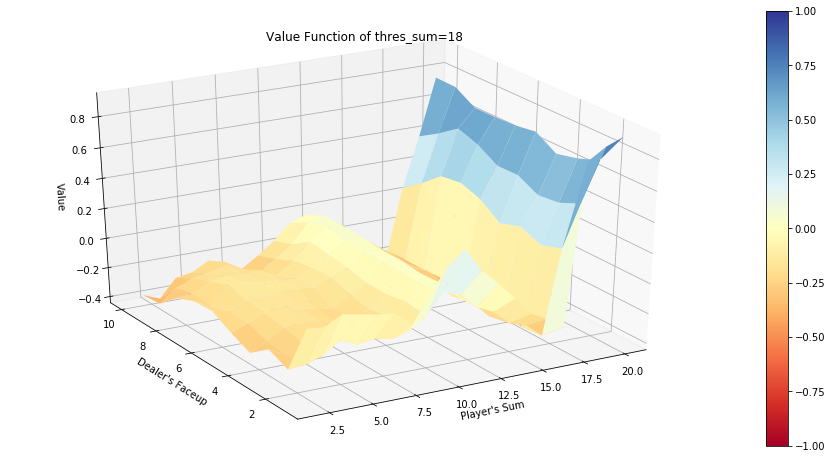

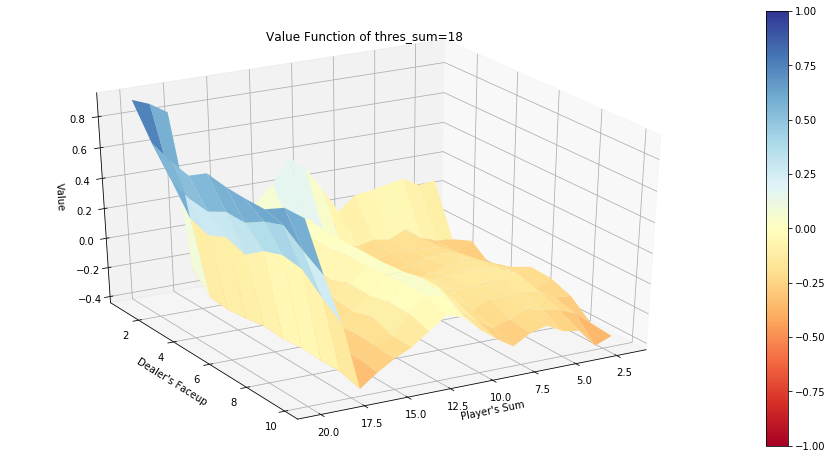

In [9]:
def plot_BlackJack(Monte_carlo_result,i):
    min_x = min(k[0] for k in Monte_carlo_result[i].keys())
    max_x = max(k[0] for k in Monte_carlo_result[i].keys())
    min_y = min(k[1] for k in Monte_carlo_result[i].keys())
    max_y = max(k[1] for k in Monte_carlo_result[i].keys())

    x_range = np.arange(min_x,max_x+1)
    y_range = np.arange(min_y,max_y+1)

    X,Y = np.meshgrid(x_range,y_range)

    Z = np.apply_along_axis(lambda x: Monte_carlo_result[i][(x[0], x[1])], 2, np.dstack([X, Y]))
    
    def plot_surface(X, Y, Z, title,degree):
        fig = plt.figure(figsize = (16,8))
        ax = fig.add_subplot(111, projection = '3d')
        surf = ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1,
                               cmap = matplotlib.cm.RdYlBu, vmin = -1.0, vmax = 1.0)
        ax.set_xlabel('Player\'s Sum')
        ax.set_ylabel('Dealer\'s Faceup')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -degree)
        fig.colorbar(surf)
        fig.savefig('./BlackJack_Visualization/BlackJack'+'_sum{}'.format(i)+'_degree{}'.format(d)+'.png')
#       plt.show()
    for d in np.arange(120,360,180):   
        plot_surface(X,Y,Z,'Value Function of thres_sum={}'.format(i),d)
        
plot_BlackJack(policy_eval,18)

In [14]:
from PIL import Image
import glob
import os

path_a = '/Users/yisongdong/Desktop/DataScienceAndMachineLearning/MachineLearning/WonderfulJourney/Reinforcement Learning/Reinforcement_Learning'
path_b = '/Users/yisongdong/Desktop/DataScienceAndMachineLearning/MachineLearning/WonderfulJourney/Reinforcement Learning/Reinforcement_Learning/BlackJack_Visualization'
os.chdir(path_b)

# Create the frames
frames = []
imgs = sorted(glob.glob('*.png'),key=os.path.getmtime)

# if you want to sort by the time, use:
# sorted(glob.glob('*.png', key=os.path.getmtime))

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
    
#Save into a GIF file that loops forever
frames[0].save('png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)

os.chdir(path_a)

<img src="BlackJack_Visualization/png_to_gif.gif" width="1500" height="1500">